In [34]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import tensorflow as tf
from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud


In [35]:
# Daten laden
data = pd.read_csv('2019-Nov.csv')

Wir fokussieren uns auf die Fragestellung, welche Produktkategorien zusammen empfohlen werden können. 
Dafür schauen wir uns an, wie die Kategorien aufgebaut sind und wie wir diese aufschlüsseln können.

# 1. Informationen Anzeigen

In [36]:
# Übersicht
data.head(10)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2
5,2019-11-01 00:00:01 UTC,view,1306894,2053013558920217191,computers.notebook,hp,360.09,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c
6,2019-11-01 00:00:01 UTC,view,1306421,2053013558920217191,computers.notebook,hp,514.56,514028527,df8184cc-3694-4549-8c8c-6b5171877376
7,2019-11-01 00:00:02 UTC,view,15900065,2053013558190408249,NaN,rondell,30.86,518574284,5e6ef132-4d7c-4730-8c7f-85aa4082588f
8,2019-11-01 00:00:02 UTC,view,12708937,2053013553559896355,NaN,michelin,72.72,532364121,0a899268-31eb-46de-898d-09b2da950b24
9,2019-11-01 00:00:02 UTC,view,1004258,2053013555631882655,electronics.smartphone,apple,732.07,532647354,d2d3d2c6-631d-489e-9fb5-06f340b85be0


In [37]:
# Info Anzeigen
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501979 entries, 0 to 67501978
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 4.5+ GB


In [38]:
# Zusammenfassende Statistik
data.describe()

,product_id,category_id,price,user_id
count,6.750198e+07,6.750198e+07,6.750198e+07,6.750198e+07
mean,1.251406e+07,2.057898e+18,2.924593e+02,5.386397e+08
std,1.725741e+07,2.012549e+16,3.556745e+02,2.288516e+07
min,1.000365e+06,2.053014e+18,0.000000e+00,1.030022e+07
25%,1.305977e+06,2.053014e+18,6.924000e+01,5.164762e+08
50%,5.100568e+06,2.053014e+18,1.657700e+02,5.350573e+08
75%,1.730075e+07,2.053014e+18,3.603400e+02,5.610794e+08
max,1.000286e+08,2.187708e+18,2.574070e+03,5.799699e+08


In [39]:
# Zählen der Einträge die nicht "NULL" sind
data.count()

event_time       67501979
event_type       67501979
product_id       67501979
category_id      67501979
category_code    45603808
brand            58277901
price            67501979
user_id          67501979
user_session     67501969
dtype: int64

In [40]:
# Zählen der Einträge, die "NULL" sind
data.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    21898171
brand             9224078
price                   0
user_id                 0
user_session           10
dtype: int64

In [41]:
# Übersicht der einzigartigen Werte im Datensatz (Anzahl)
num_users = data['user_id'].nunique()
num_products = data['product_id'].nunique()
num_categories = data['category_id'].nunique()
num_taxonomies = data['category_code'].nunique()
num_brands = data['brand'].nunique()
print('Total number of users: ',num_users)
print('Total number of products: ', num_products)
print('Total number of categories: ', num_categories)
print('Total number of taxonomies: ', num_taxonomies)
print('Total number of brands: ', num_brands)

Total number of users:  3696117
Total number of products:  190662
Total number of categories:  684
Total number of taxonomies:  129
Total number of brands:  4200


# 2. Analyse der Kategorien

In [42]:
data_copy = data.copy()
print('Copy successfully')

Copy successfully


In [43]:
# Punktnotation im category_code aufheben und dann parent und child jeweils eigene spalte
data_copy[['main_category', 'sub_category']] = data_copy['category_code'].str.split('.', n=1, expand=True)
print('Split successfully')

: 

In [ ]:
# Man könnte Null werte rauswerfen, aber das macht die analyse schwieriger
# data_copy_non_null = data.dropna(subset=['category_code'])

In [2]:
# Speichern von data_copy, weil der Split lange dauert und um einen Snapshot zu haben.
data_copy.to_csv ('data_split_categories.csv', index = None, header=True) 


NameError: name 'data_copy' is not defined

In [3]:
data_categories = pd.read_csv(f'data_split_categories.csv')

In [4]:
# Spalten umformatieren
data_categories = data_categories.drop(columns=['category_code'])
new_order = ['event_time', 'event_type', 'product_id', 'category_id', 'main_category', 'sub_category', 'brand', 'price', 'user_id', 'user_session']
data_categories = data_categories[new_order]
data_categories.head(10)

,event_time,event_type,product_id,category_id,main_category,sub_category,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics,smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances,sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances,kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics,smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2
5,2019-11-01 00:00:01 UTC,view,1306894,2053013558920217191,computers,notebook,hp,360.09,520772685,816a59f3-f5ae-4ccd-9b23-82aa8c23d33c
6,2019-11-01 00:00:01 UTC,view,1306421,2053013558920217191,computers,notebook,hp,514.56,514028527,df8184cc-3694-4549-8c8c-6b5171877376
7,2019-11-01 00:00:02 UTC,view,15900065,2053013558190408249,NaN,NaN,rondell,30.86,518574284,5e6ef132-4d7c-4730-8c7f-85aa4082588f
8,2019-11-01 00:00:02 UTC,view,12708937,2053013553559896355,NaN,NaN,michelin,72.72,532364121,0a899268-31eb-46de-898d-09b2da950b24
9,2019-11-01 00:00:02 UTC,view,1004258,2053013555631882655,electronics,smartphone,apple,732.07,532647354,d2d3d2c6-631d-489e-9fb5-06f340b85be0


In [ ]:
mainCat_values = data_categories.groupby('main_category')['product_id'].nunique().sort_values(ascending=False)
mainCat_names = mainCat_values.index
mainCat_values

main_category
apparel         16884
electronics     15900
appliances      13150
computers        8696
furniture        7950
construction     6468
kids             5644
accessories      2857
sport            2575
auto             1533
stationery        853
country_yard      191
medicine           28
Name: product_id, dtype: int64

In [ ]:
# Übersicht über die Haupt-Kategorien 
print('Number of main-categories: ', len(mainCat_names))
fig = px.pie(names=mainCat_names, values=mainCat_values, hole=0.3)
fig.update_layout({"title":{"text":"Main category distribution", "x":0.50}})
fig.show()

Number of main-categories:  13


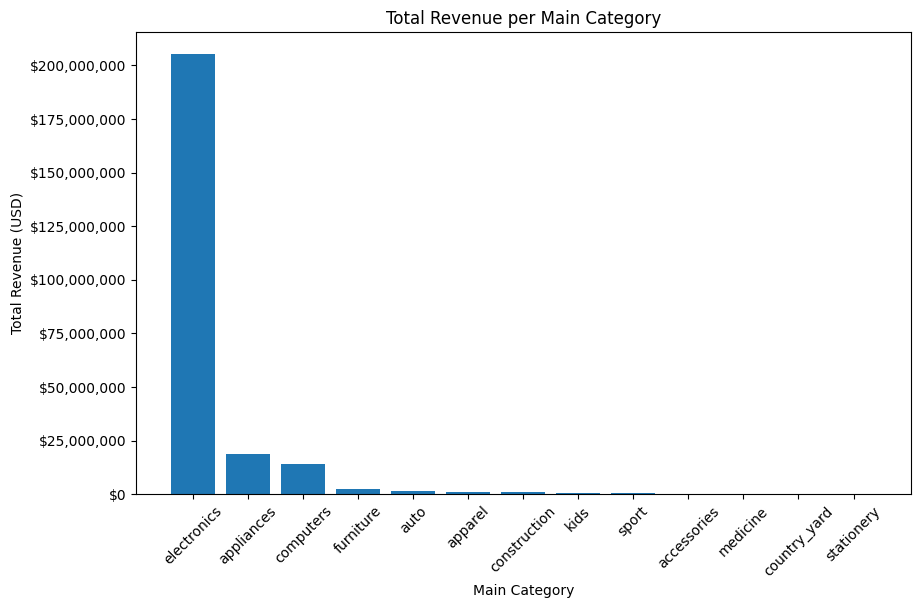

In [ ]:
# Schauen wir, wie viel Umsatz diese Kategorien in dem Monat erzielt haben.

purchases = data_categories[data_categories['event_type'] == 'purchase']

revenue_per_main_category = purchases.groupby('main_category')['price'].sum().reset_index()

revenue_per_main_category = revenue_per_main_category.sort_values('price', ascending=False)

# Erstellen des Plots
plt.figure(figsize=(10, 6))
plt.bar(revenue_per_main_category['main_category'], revenue_per_main_category['price'])
plt.xlabel('Main Category')
plt.ylabel('Total Revenue (USD)')

# Formatierung der y-Achse, um Währung und Lesbarkeit zu verbessern
formatter = ticker.FuncFormatter(lambda x, pos: '${:,.0f}'.format(x))
plt.gca().yaxis.set_major_formatter(formatter)

plt.title('Total Revenue per Main Category')
plt.xticks(rotation=45)  # Drehen der Beschriftungen für bessere Lesbarkeit
plt.show()

In [ ]:
# Die letzten vier Kategorien sehen wie null aus, deswegen schauen wir genauer rein: 
categories = ["accessories", "country_yard", "medicine", "stationery"]
revenue_specific_categories = data_categories[data_categories['main_category'].isin(categories)].groupby('main_category')['price'].sum()
print(revenue_specific_categories)

main_category
accessories     25400690.55
country_yard     4885789.81
medicine         1165625.37
stationery        390395.25
Name: price, dtype: float64


In [ ]:
# Übersicht über die Sub-Kategorien
subCat_values = data_categories.groupby('sub_category')['product_id'].nunique().sort_values(ascending=False)
subCat_names = subCat_values.index

print('Number of sub-categories: ', len(subCat_names))

other_value = subCat_values[10:].sum()
subCat_names_with_other = np.append(subCat_names[:10], 'Other')
subCat_names_with_other  = np.append(subCat_values[:10], other_value)

fig = px.pie(names=subCat_names_with_other , values=subCat_names_with_other , hole=0.3)
fig.update_layout({"title":{"text":"Sub category distribution", "x":0.50}})
fig.show()


Number of sub-categories:  129


In [8]:
import numpy as np
import pandas as pd
import plotly.express as px

# Angenommen, 'data_categories' ist Ihr DataFrame und enthält 'sub_category' und 'product_id'

# Übersicht über die Sub-Kategorien
subCat_values = data_categories.groupby('sub_category')['product_id'].nunique().sort_values(ascending=False)
subCat_names = subCat_values.index

print('Number of sub-categories: ', len(subCat_names))

# Summiere die Anzahlen der Produkte für 'Other'
other_value = subCat_values[10:].sum()

# Erstelle Arrays für die ersten 10 Subkategorien und 'Other'
subCat_names_with_other = np.append(subCat_names[:10], 'Other')
subCat_values_with_other = np.append(subCat_values[:10], other_value)

# Erstelle das Tortendiagramm mit Plotly Express
fig = px.pie(names=subCat_names_with_other, values=subCat_values_with_other, hole=0.3)
fig.update_layout({"title": {"text": "Sub category distribution", "x": 0.50}})

# Zeige das Diagramm an
fig.show()


Number of sub-categories:  129


In [ ]:
# Übersicht über die einzelnen Sub-Kategorien innerhalb ihrer Hauptkategorie.
category_counts = data_categories.drop_duplicates(subset='product_id').groupby(['main_category', 'sub_category']).size().reset_index(name='count')

fig = px.treemap(category_counts, path=[px.Constant("all"), 'main_category', 'sub_category'], values='count',
                  color='count', hover_data=['count'],
                  color_continuous_scale='YlGnBu',)
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()

In [ ]:
no_categoryCode = data_categories.drop_duplicates(subset='product_id')['main_category'].isna().sum()
have_categoryCode = category_counts['count'].sum()
print('Anteil an Produkten mit category_code: {0:.2f}%'.format(100*have_categoryCode/(have_categoryCode+no_categoryCode)))
print('Anteil an Produkten ohne category_code: {0:.2f}%'.format(100*no_categoryCode/(have_categoryCode+no_categoryCode)))

# Hier können wir deutlich sehen, dass mehr als die Hälfte der Daten keinen category_code hat. Das bedeutet, dass sie ohne
# das Imputieren mit Hilfe der anderen Spalten keinen Wert für eine Analyse von zusammenhängenden Produkten haben.
# Jedoch können wir hier nicht einfach random diverse Werte einfüllen, da dies das Bild verfälschen könnte.

Anteil an Produkten mit category_code: 43.39%
Anteil an Produkten ohne category_code: 56.61%


# 3. Betrachtung der 0-Preise

In [ ]:
# Wir entnehmen alle Einträge mit 0-Preisen
zero_price = data_categories[data_categories['price']==0]

In [ ]:
# Zählen der einzigartigen Produkt-IDs mit einem Preis von 0
zeroprice_total = zero_price['product_id'].nunique()
print('Gesamtanzahl der Produkte mit einem Preis von 0: ', zeroprice_total)

# Berechnen des Prozentsatzes der 0-Preis-Produkte ohne Markenangabe
nobrand_zeroprice_percentage = 100 * zero_price[zero_price['brand'].isna()]['product_id'].nunique() / zeroprice_total
print('Prozentsatz der 0-Preis-Produkte ohne Marke: {0:.2f}%'.format(nobrand_zeroprice_percentage))

# Berechnen des Prozentsatzes der 0-Preis-Produkte im Verhältnis zu allen Produkten
zeroprice_percentage = 100 * zero_price['product_id'].nunique() / data_categories['product_id'].nunique()
print('Prozentsatz der 0-Preis-Produkte im Verhältnis zu allen Produkten: {0:.2f}%'.format(zeroprice_percentage))

# Berechnen des Prozentsatzes der Produkte ohne Markenangabe im Verhältnis zu allen Produkten
nobrand_percentage = 100 * data_categories[data_categories['brand'].isna()]['product_id'].nunique() / data_categories['product_id'].nunique()
print('Prozentsatz der Produkte ohne Marke im Verhältnis zu allen Produkten: {0:.2f}%'.format(nobrand_percentage))

Gesamtanzahl der Produkte mit einem Preis von 0:  13235
Prozentsatz der 0-Preis-Produkte ohne Marke: 100.00%
Prozentsatz der 0-Preis-Produkte im Verhältnis zu allen Produkten: 6.94%
Prozentsatz der Produkte ohne Marke im Verhältnis zu allen Produkten: 29.34%


Die Nullpreise können unterschiedliche Ursachen haben, zum Einen könnten es Platzhalterpreise sein. Zum Anderen können es Gratisprodukte sein, welche dem Kunden angeboten werden. Auffällig ist, dass alle 0-Preis Produkte auch keine Marke haben.

In [ ]:
# Gruppieren des Hauptkategorie und Anzahl Null Preise
zeroprice_mainCat = zero_price.groupby('main_category')['product_id'].nunique()
zeroprice_mainCat

main_category
accessories      159
apparel         2089
appliances       442
auto             328
computers        532
construction     259
country_yard       3
electronics      539
furniture        613
kids             320
sport            297
stationery        21
Name: product_id, dtype: int64

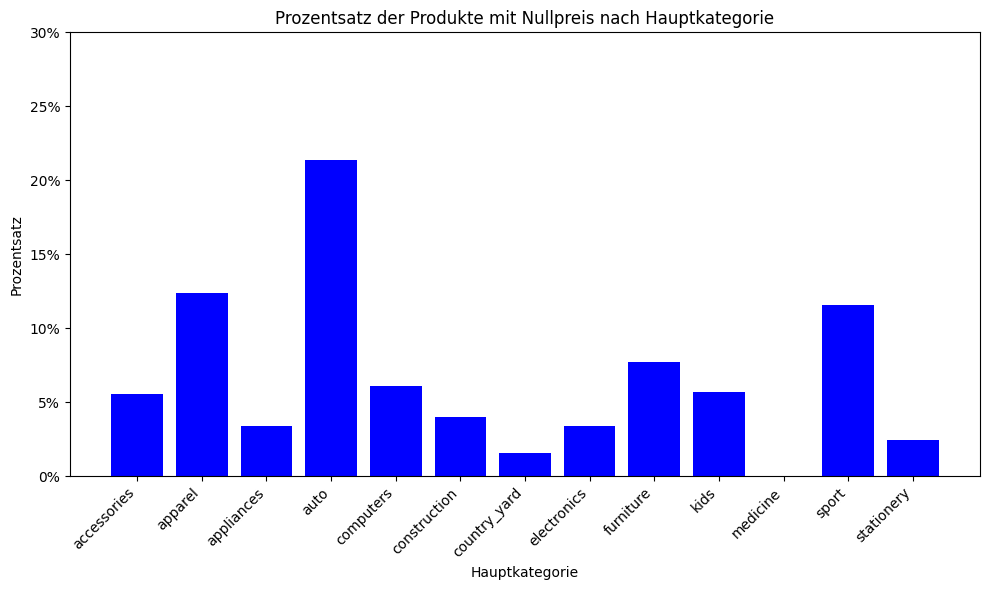

In [ ]:
# Berechnen des Prozentsatzes der Produkte mit Nullpreis pro Hauptkategorie
prozent_zero_price = zeroprice_mainCat / mainCat_values * 100

# Erstellen eines Balkendiagramms
plt.figure(figsize=(10, 6))
plt.bar(prozent_zero_price.index, prozent_zero_price, color='blue')
plt.title('Prozentsatz der Produkte mit Nullpreis nach Hauptkategorie')
plt.xlabel('Hauptkategorie')
plt.ylabel('Prozentsatz')

# Drehen der x-Achsen-Beschriftung für eine bessere Lesbarkeit
plt.xticks(rotation=45, ha='right')

# Festlegen der y-Achsen-Grenze auf 0-30 für Prozentsätze
plt.ylim(0, 30)

# Formatierung der y-Achsen-Beschriftungen als Prozentsätze
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}%'))

# Anzeigen des Plots
plt.tight_layout()
plt.show()


In [12]:
# Nochmal die Anzahl der Null einträge plotten

# Übersicht über die Sub-Kategorien
subCat_values = data_categories.groupby('sub_category')['product_id'].nunique().sort_values(ascending=False)
subCat_names = subCat_values.index

print('Number of sub-categories: ', len(subCat_names))

# Summiere die Anzahlen der Produkte für 'Other'
other_value = subCat_values[10:].sum()

# Erstelle Arrays für die ersten 10 Subkategorien und 'Other'
subCat_names_with_other = np.append(subCat_names[:10], 'Other')
subCat_values_with_other = np.append(subCat_values[:10], other_value)

# Erstelle das Tortendiagramm mit Plotly Express
fig = px.pie(names=subCat_names_with_other, values=subCat_values_with_other, hole=0.3)
fig.update_layout({"title": {"text": "Sub category distribution", "x": 0.50}})

# Zeige das Diagramm an
fig.show()


Number of sub-categories:  129


Wie in dem Plot zu sehen, ist die Kategorie "Auto" am mit ca 22 % am meisten von den 0-Preisen betroffen.
Bekleidung und Sportartikel liegen bei einem Anteil von über 10% währen die anderen Kategorien darunter liegen.

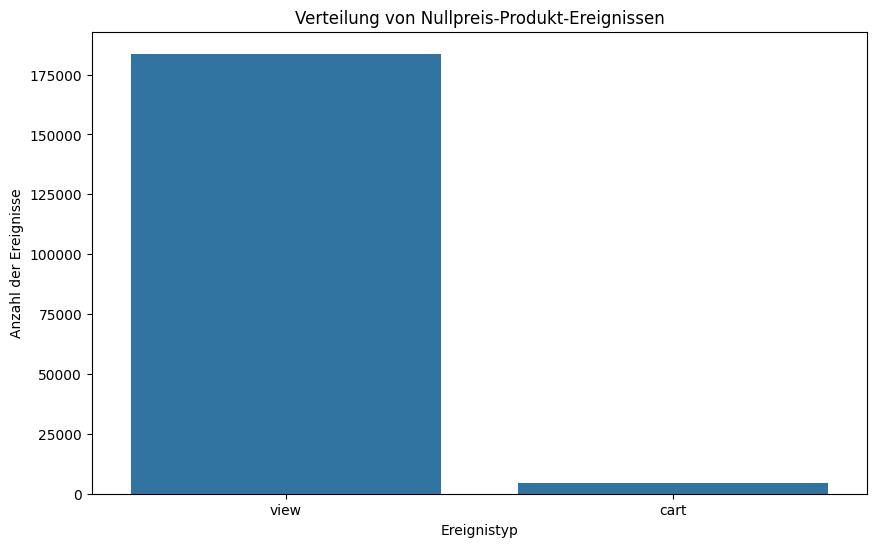

In [ ]:
# Schauen wir uns die Verteilung an:

# Daten für das Balkendiagramm
zeroprice_event_names = zero_price['event_type'].unique()
zeroprice_event_values = zero_price['event_type'].value_counts()

# Erstellen eines Balkendiagramms
plt.figure(figsize=(10, 6))
sns.barplot(x=zeroprice_event_values.index, y=zeroprice_event_values.values)

# Hinzufügen von Titel und Achsenbeschriftungen
plt.title('Verteilung von Nullpreis-Produkt-Ereignissen')
plt.xlabel('Ereignistyp')
plt.ylabel('Anzahl der Ereignisse')

# Anzeigen des Diagramms
plt.show()

# vielleicht noch eine anzeige für das verhältnis

Es wird ersichtlich, dass 0-Preise überwiegend in view Ereignissen vorkommen, was darauf schliesst dass diese Produkte nicht gekauft werden können oder es sich um einen Artikel handelt, der einen Platzhalterpreis hat. Bei den Produkten im Cart kann es sich um kostenlose Promo-Artikel handeln

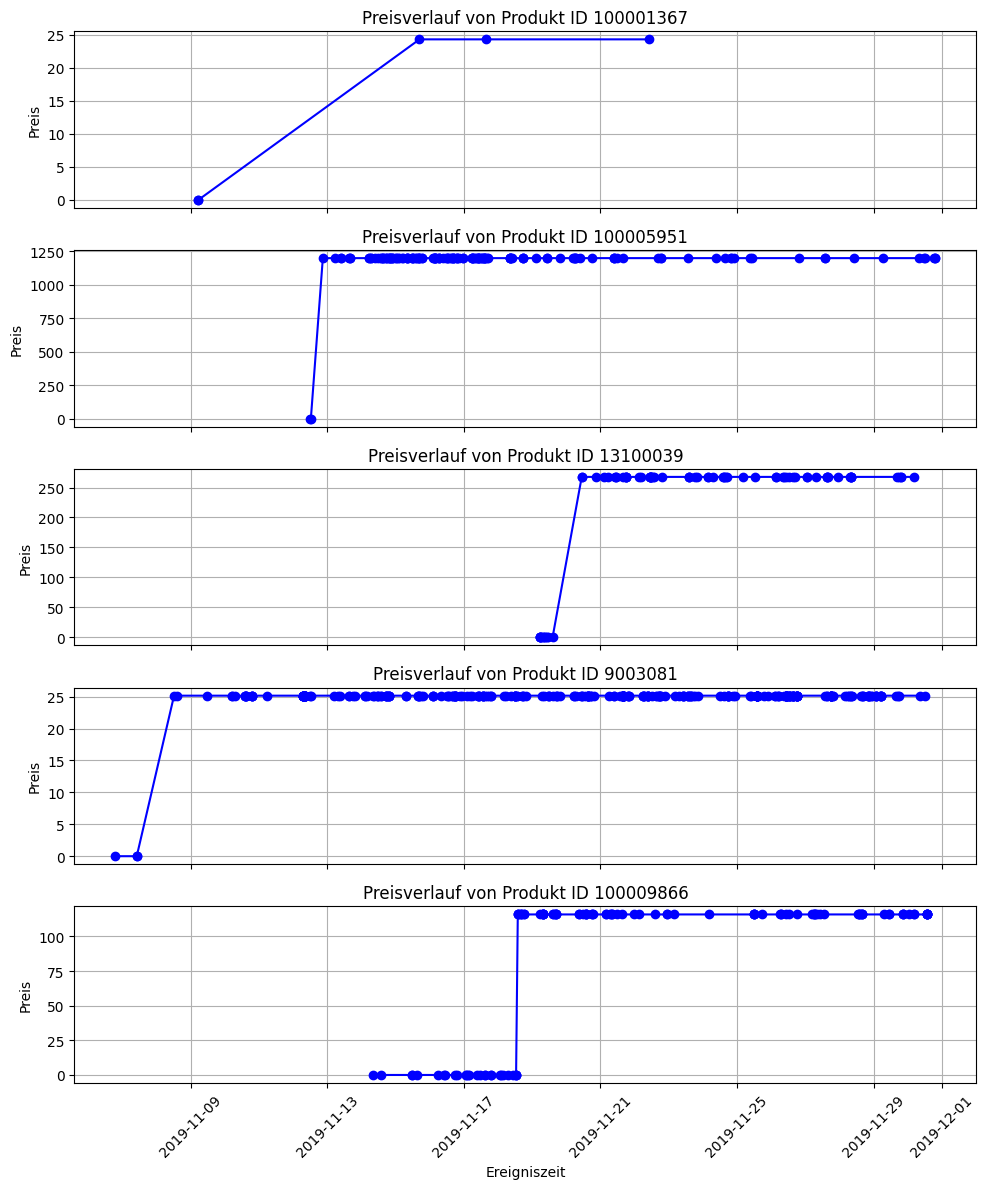

In [ ]:
# Schauen wir uns an, wie sich Produkte verhalten, die einen initialen Preis von Null haben

# Konvertieren von 'event_time' in das datetime-Format
data_categories['event_time'] = pd.to_datetime(data_categories['event_time'])

# Sortieren der Daten nach 'product_id' und 'event_time'
data_sorted = data_categories.sort_values(by=['product_id', 'event_time'])

# Gruppieren nach 'product_id' und Nehmen des ersten Eintrags jeder Gruppe
first_price_per_product = data_sorted.groupby('product_id').first().reset_index()

# Filtern der Produkte mit einem initialen Preis von 0
initial_zero_price_products = first_price_per_product[first_price_per_product['price'] == 0]

# Auswahl von 5 Produkten mit einem initialen Preis von 0
selected_products = initial_zero_price_products.sample(n=5, random_state=1)['product_id']

# Erstellen von Subplots für jedes ausgewählte Produkt
fig, axs = plt.subplots(len(selected_products), 1, figsize=(10, 12), sharex=True)

# Preisverlauf für jedes ausgewählte Produkt plotten
for i, product_id in enumerate(selected_products):
    product_data = data_categories[data_categories['product_id'] == product_id]
    axs[i].plot(product_data['event_time'], product_data['price'], marker='o', linestyle='-', color='b')
    axs[i].set_title(f'Preisverlauf von Produkt ID {product_id}')
    axs[i].set_ylabel('Preis')
    axs[i].grid(True)

# Beschriftung der x-Achse für das unterste Diagramm
axs[len(selected_products) - 1].set_xlabel('Ereigniszeit')

# Drehen der x-Achsen-Beschriftungen für eine bessere Lesbarkeit
plt.xticks(rotation=45)

# Anpassen des Layouts und Anzeigen des Diagramms
plt.tight_layout()
plt.show()



Wir sehen dass manche Produkte einen initialen 0-Preis haben, später jedoch einen neuen Preis erhalten.
Die Gründe dafür können ein Platzhalter-Preis sein, aber auch Angebote oder gar ein Fehler beim Eintragen der Daten.

In [ ]:
zeroprice_products = data_categories.groupby('product_id')
mean_price = zeroprice_products['price'].mean()
zeromean_price = mean_price[mean_price==0]
zeromean_price

product_id
1002883      0.0
1004942      0.0
1005276      0.0
1304844      0.0
1500117      0.0
            ... 
100028525    0.0
100028530    0.0
100028536    0.0
100028537    0.0
100028554    0.0
Name: price, Length: 1378, dtype: float64

Wenn wir uns den Durchschnitt anschauen, sehen wir, dass einige Einträge dauerhauft einen 0-Preis haben (bis jetzt). 
Der Anteil ist aber gering (Length: 1378)

# 4. Data Observability

## 4.1 NULL-Rates

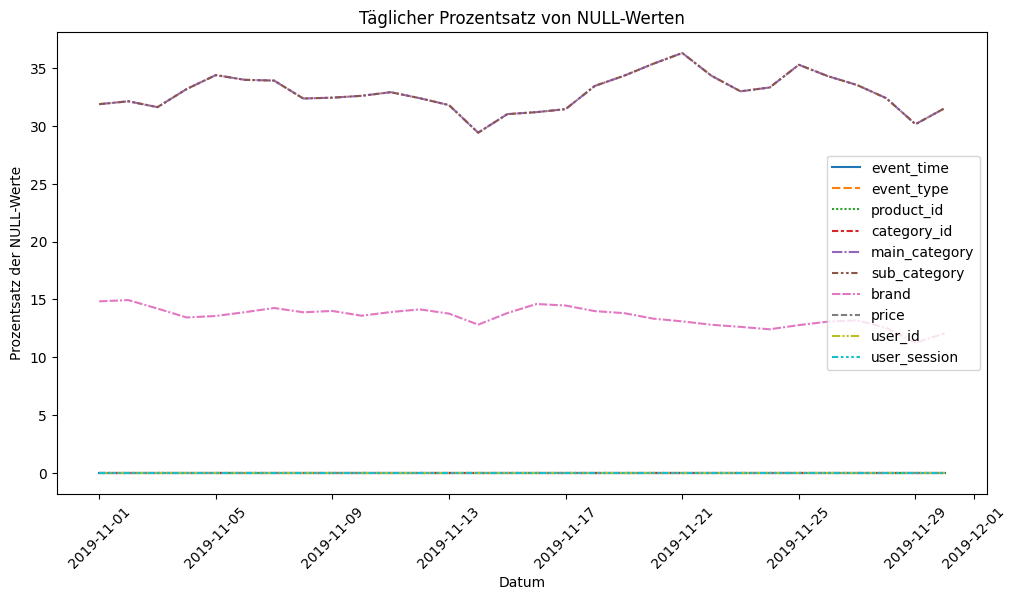

In [5]:
# Angenommen, 'data' ist Ihr DataFrame und enthält 'event_time' sowie andere Spalten

# Konvertieren von 'event_time' in das datetime-Format
data_categories['event_time'] = pd.to_datetime(data_categories['event_time'])

# Berechnen des täglichen Prozentsatzes der NULL-Werte
null_percentage_per_day = data_categories.groupby(data_categories['event_time'].dt.date).apply(lambda x: x.isnull().mean() * 100)

# Zeitreihendiagramm der NULL-Prozentsätze
plt.figure(figsize=(12, 6))
sns.lineplot(data=null_percentage_per_day)
plt.title('Täglicher Prozentsatz von NULL-Werten')
plt.xlabel('Datum')
plt.ylabel('Prozentsatz der NULL-Werte')
plt.xticks(rotation=45)
plt.show()

Anhand des Grafen erkennen wir, dass die Einträge mit NULL-Werten für category_code zwischen 30 und 35 % bewegen und die Einträge für Brand zwischen 13 und 16% pendeln. Wir können hier dementsprechend ein Muster erkennen.

Wenn diese Daten im realen Leben alle 24 Stunden zu einer bestimmten Uhrzeit bereitgestellt werden, könnte man einen Schwellwert definieren, um zu sehen ob sich die Anzahl der NULL-Einträge noch im Rahmen befindet.

Wir haben uns dazu entschieden, sämtliche Einträge mit NULL-Werten in eine eigene tabelle zu extrahieren, mit deren Hilfe man spätere analysen fahren kann.

## 4.2 Schema-Changes

Zur Darstellung von Schema Changes speichern wir das Schema von unserem DataFrame in einem JSON und vergleichen dieses "historische Schema" mit dem aktuellen vom DataFrame. 

In [6]:
# Extrahieren des Schemas als Dictionary
schema = {col: str(data_categories[col].dtype) for col in data_categories.columns}

# Speichern des Schemas in einer JSON-Datei
with open('schema.json', 'w') as file:
    json.dump(schema, file)

print("Schema gespeichert.")


Schema gespeichert.


In [7]:
# Laden des gespeicherten Schemas aus der Datei
with open('schema.json', 'r') as file:
    saved_schema = json.load(file)

# Vergleichen des geladenen Schemas mit dem aktuellen Schema des DataFrames
def compare_schema(current_df, saved_schema):
    current_schema = {col: str(current_df[col].dtype) for col in current_df.columns}
    if current_schema != saved_schema:
        print("Schemaänderungen erkannt!")
        print("Aktuelles Schema:", current_schema)
        print("Gespeichertes Schema:", saved_schema)
    else:
        print("Keine Schemaänderungen.")

# Beispiel für die Verwendung der Funktion
compare_schema(data_categories, saved_schema)


Keine Schemaänderungen.


Das was wir hier oben sehen ist natürlich nur ein simpler Vergleich.
Wenn dieser Vergleich bzw. Alert im realen Leben aufgebaut werden soll, 
stellen wir ihn uns wie folgt vor:

Als erstes Dokumentieren wir das Schema unserer Datenquelle, in unserem Fall die Tabelle in
MySQL. Das Schema wird dann in einer eigenen schema-tabelle gespeichert. Diese Tabelle dient dazu alle (absichtlichen)
Schemaänderungen zu dokumentieren.

Anschließend würde ein Prozess definiert werden, der das aktuelle Schema der Tabelle überwacht und mit
der aktuellsten dokumentierten Version des Schemas vergleicht.

Zudem kann ein Benachrichtungssystem eingeführt werden, also dass man eine E-Mail erhält, wenn das System eine 
Schemaänderung feststellt.